--- Starting Data Loading and Wrangling ---
Datasets loaded successfully: titles.csv, credits.csv

--- Titles DataFrame Head ---
        id                        title   type  \
0  ts20945            The Three Stooges   SHOW   
1  tm19248                  The General  MOVIE   
2  tm82253  The Best Years of Our Lives  MOVIE   
3  tm83884              His Girl Friday  MOVIE   
4  tm56584            In a Lonely Place  MOVIE   

                                         description  release_year  \
0  The Three Stooges were an American vaudeville ...          1934   
1  During America’s Civil War, Union spies steal ...          1926   
2  It's the hope that sustains the spirit of ever...          1946   
3  Hildy, the journalist former wife of newspaper...          1940   
4  An aspiring actress begins to suspect that her...          1950   

  age_certification  runtime  \
0             TV-PG       19   
1               NaN       78   
2               NaN      171   
3               NaN  

C:\Users\91965\AppData\Local\Temp\ipykernel_12576\931623521.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=titles_df, palette='viridis')


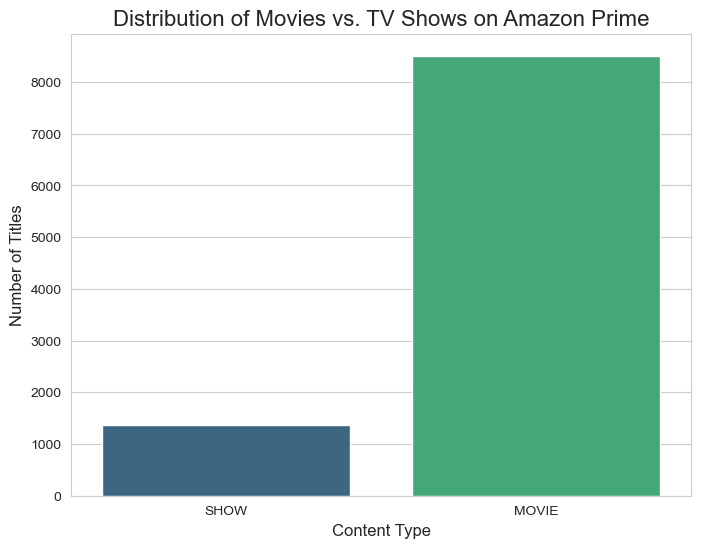

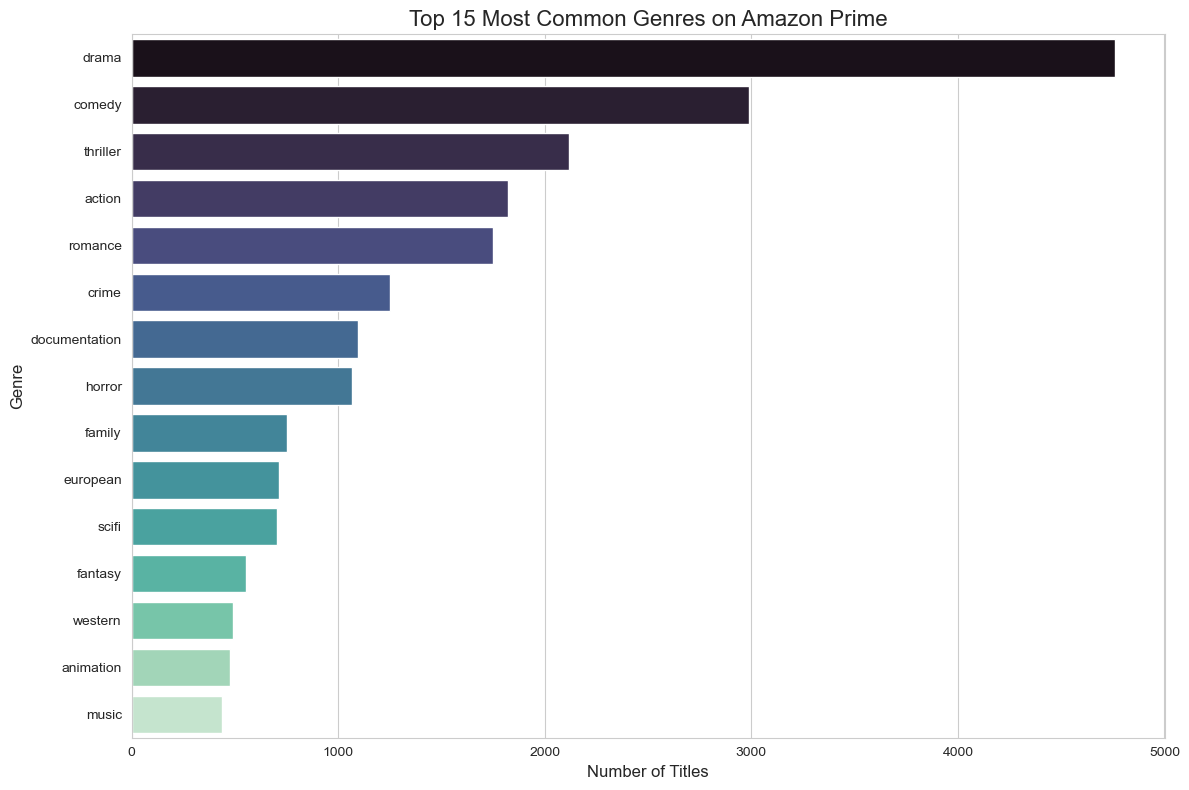

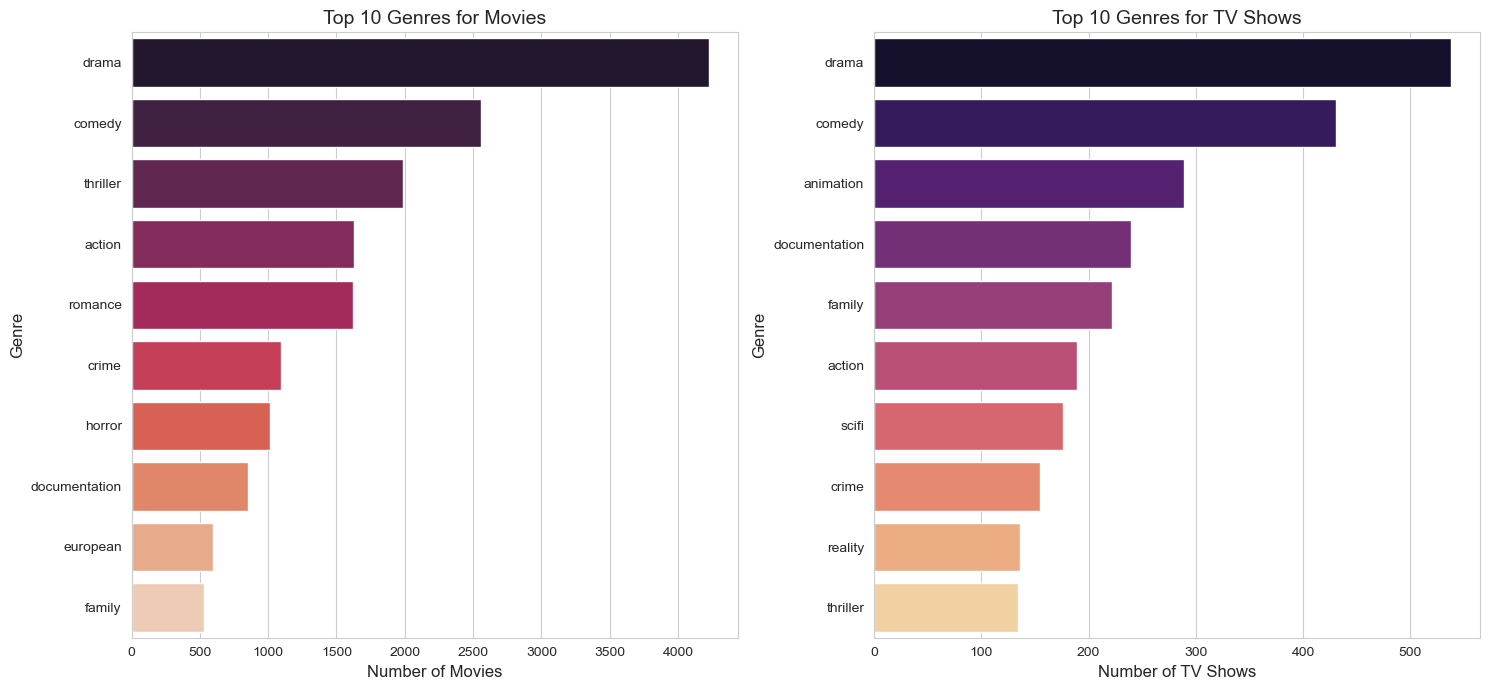

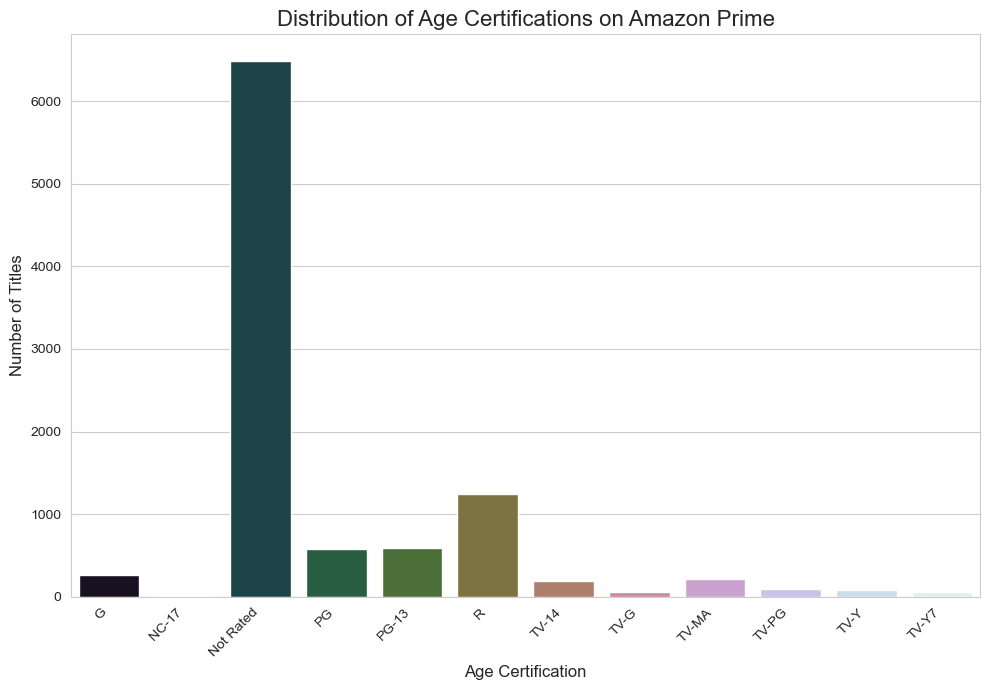

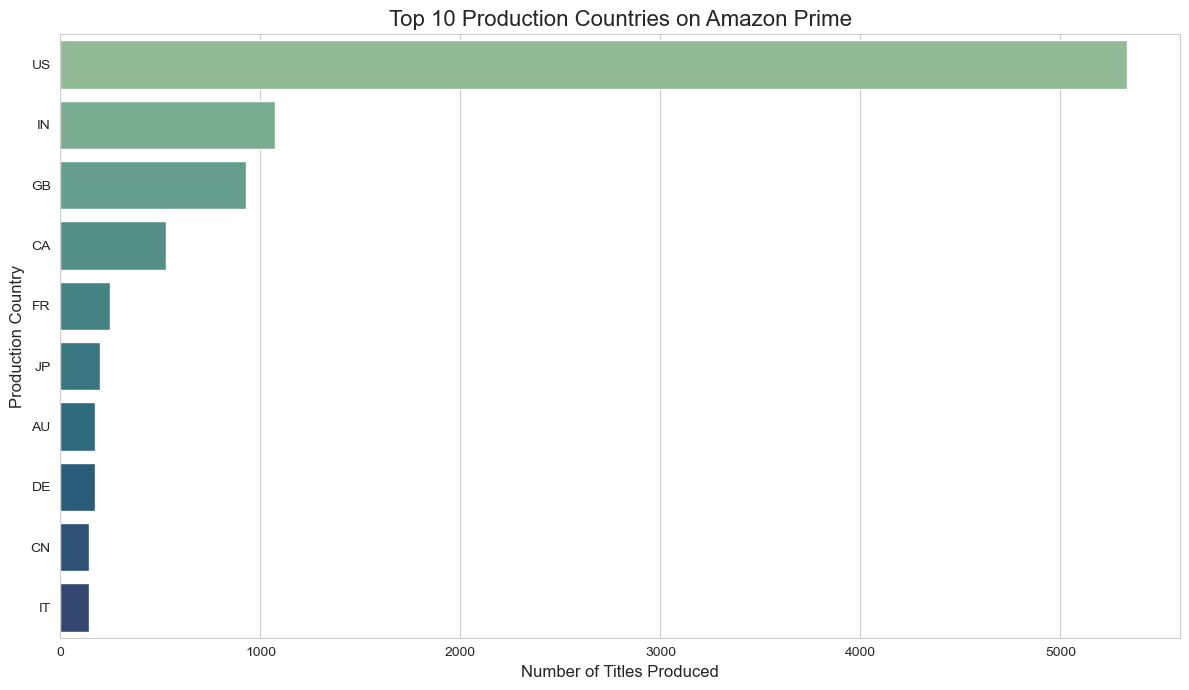

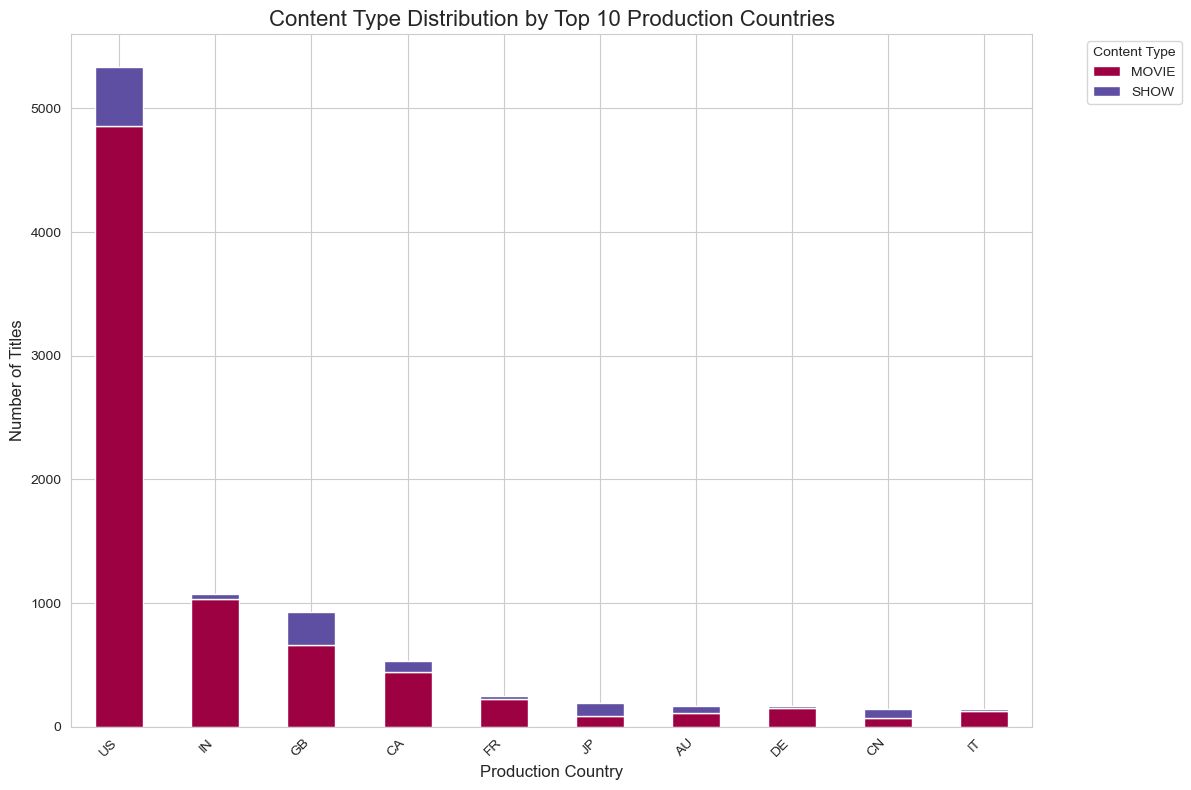

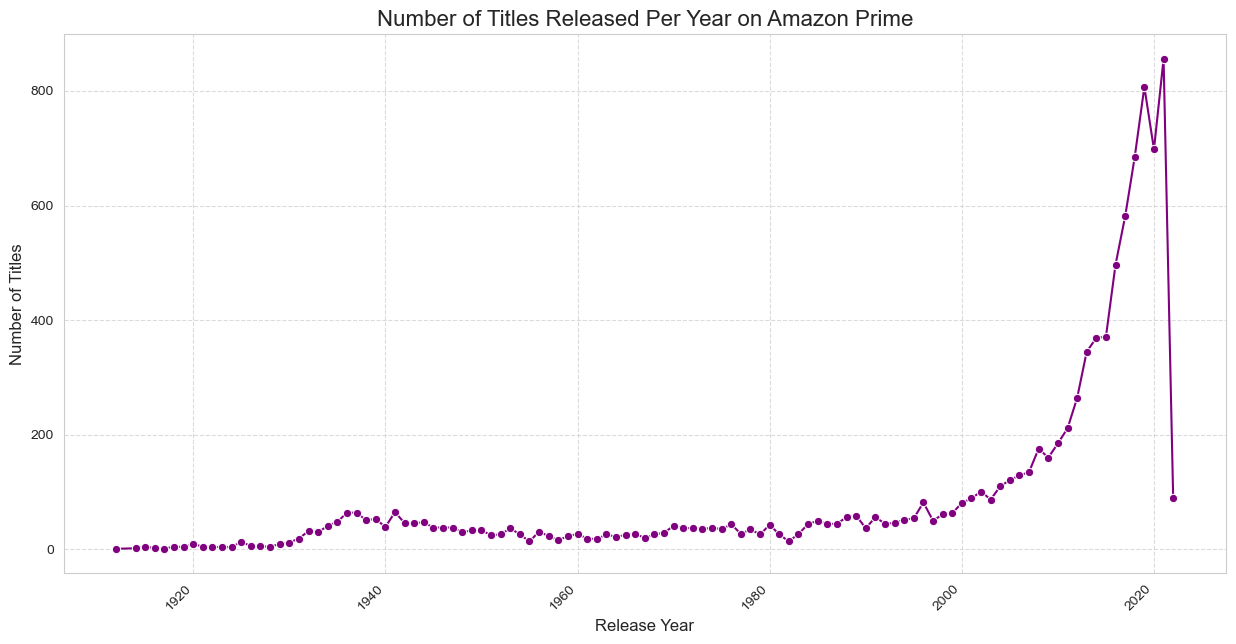

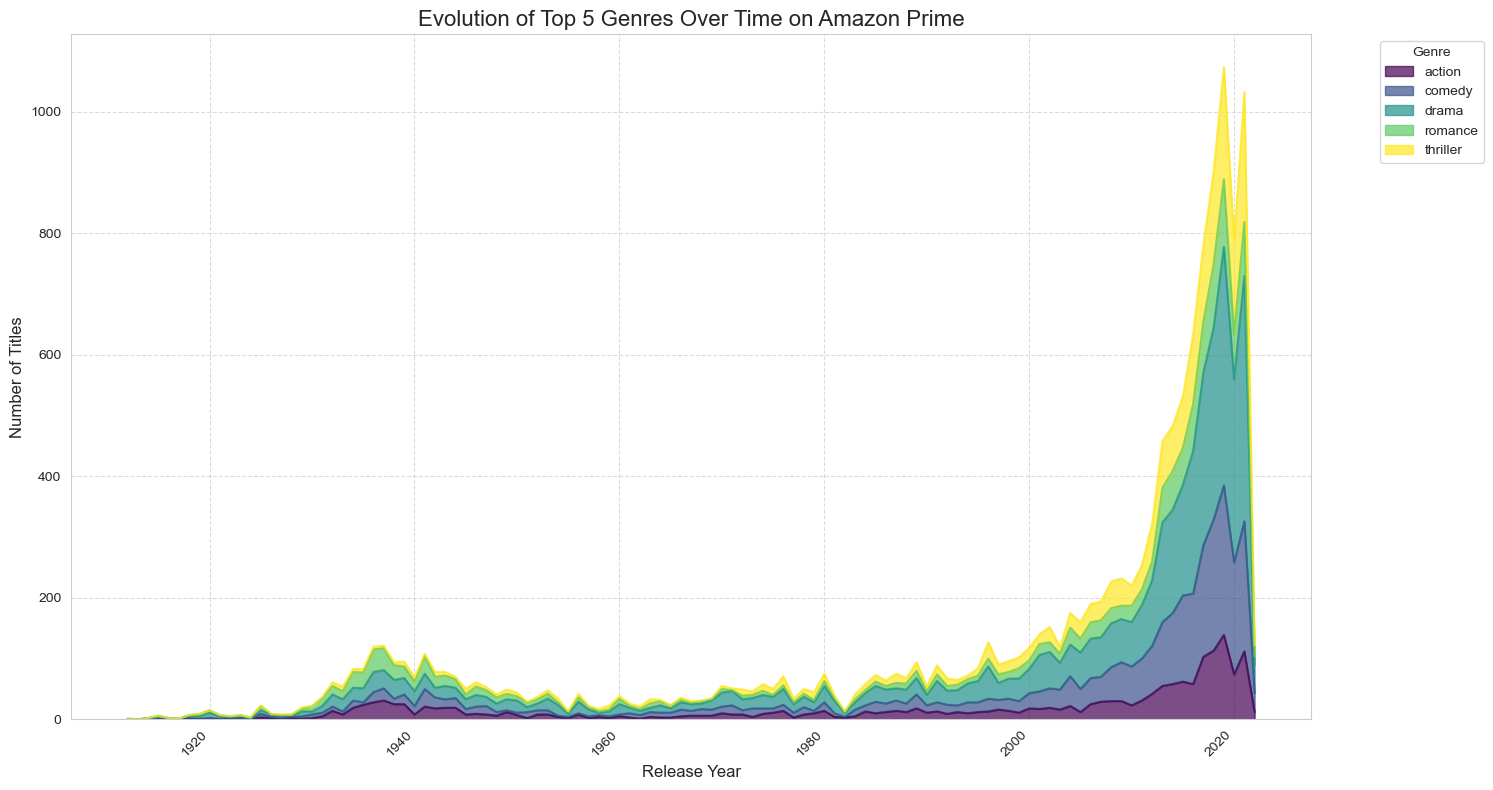

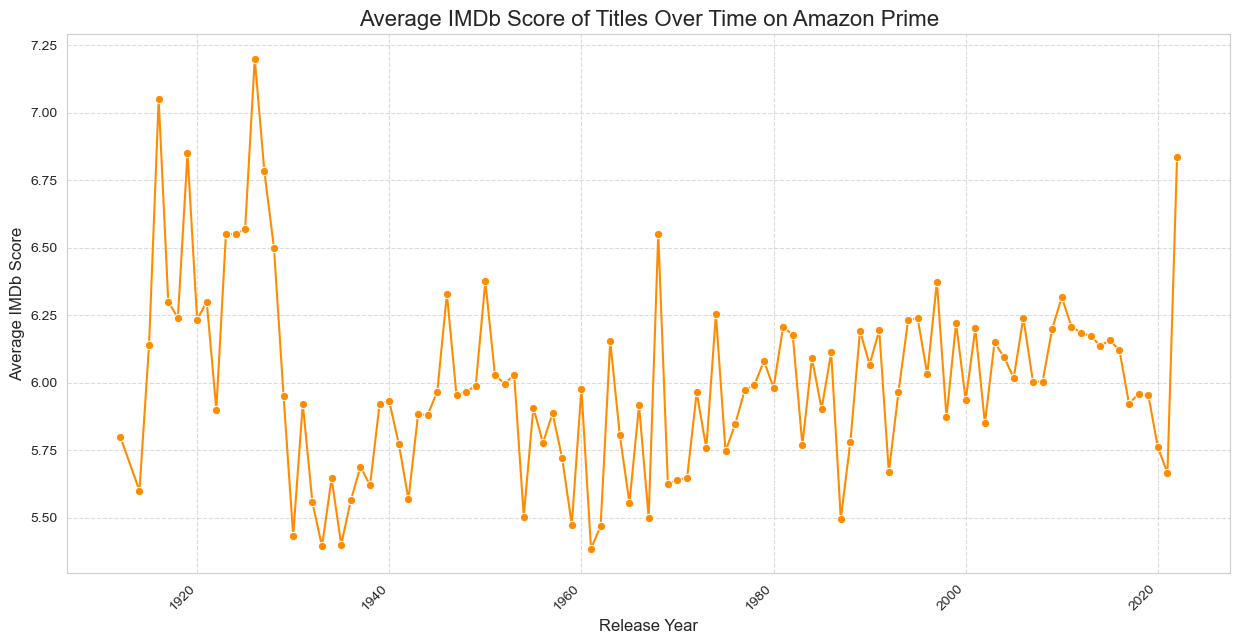

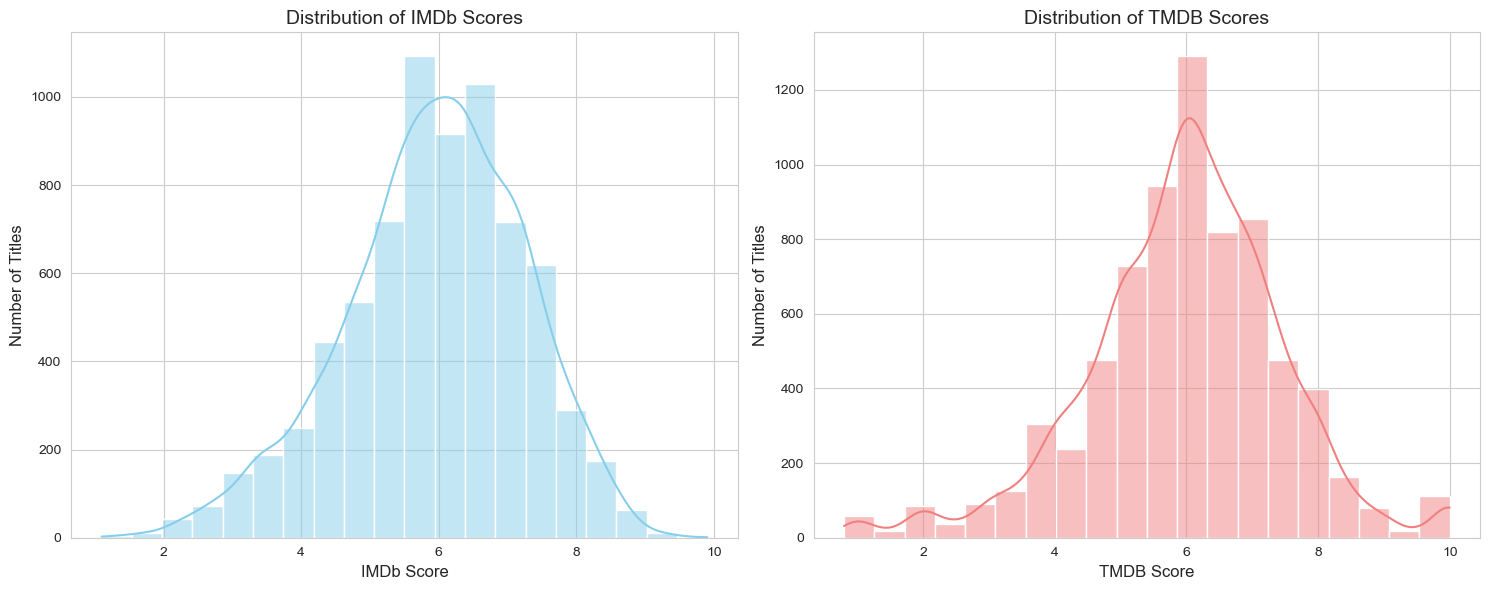

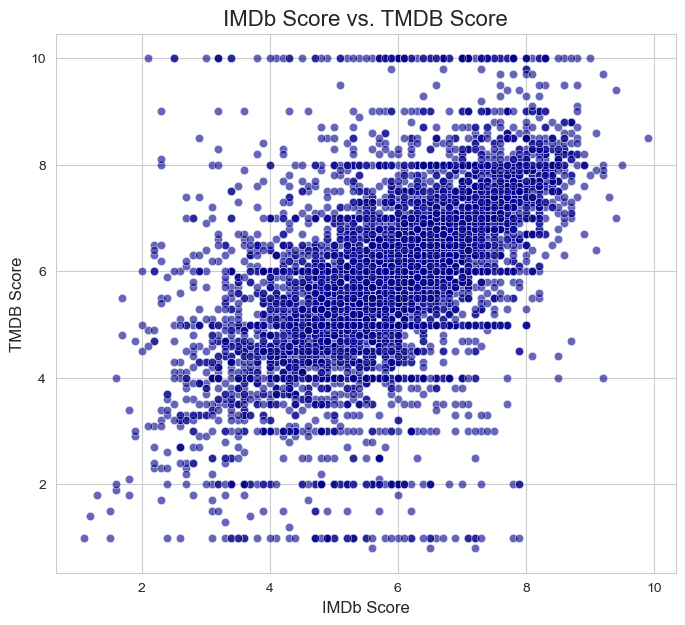

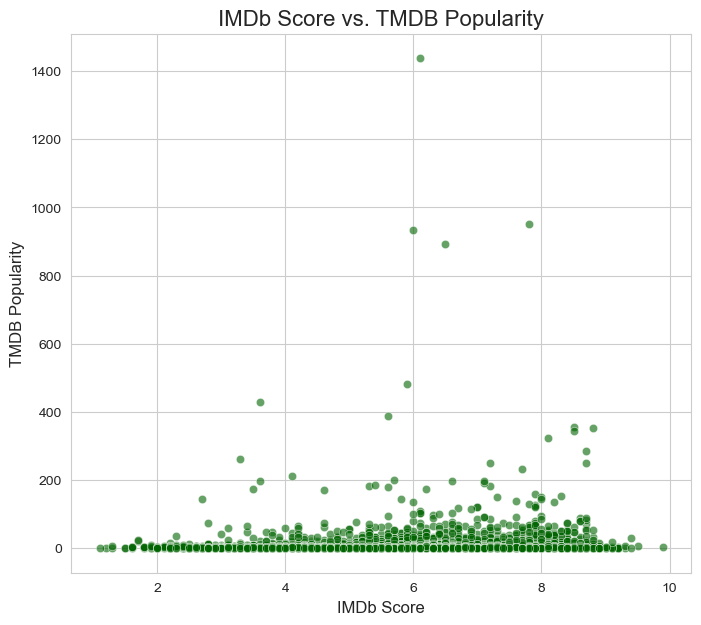

C:\Users\91965\AppData\Local\Temp\ipykernel_12576\931623521.py:380: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imdb_score', y='title', data=top_rated_movies, palette='Blues_d')


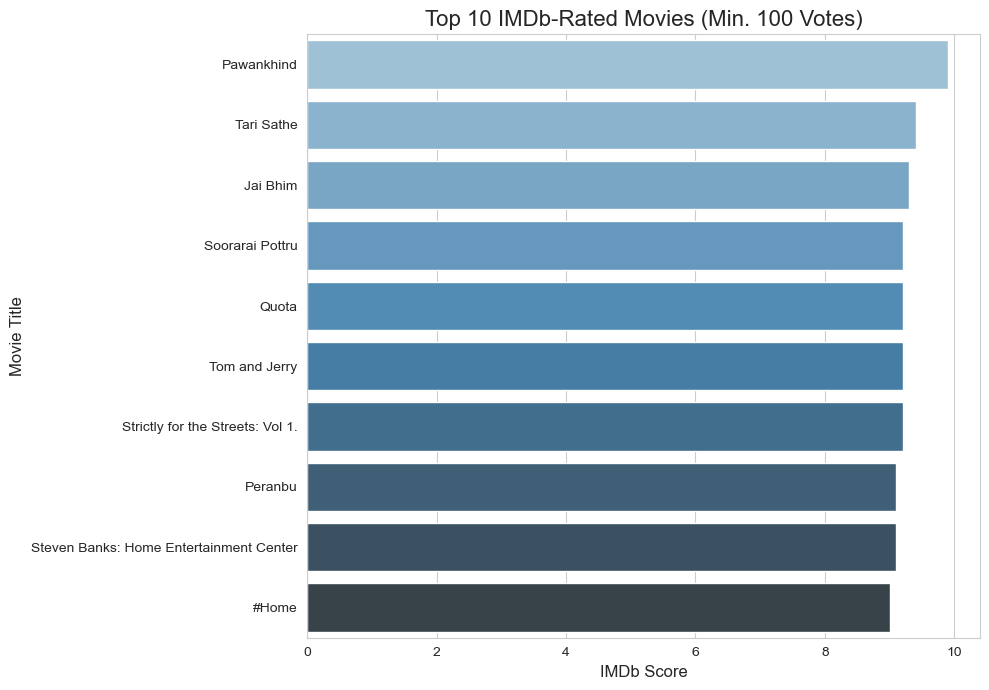

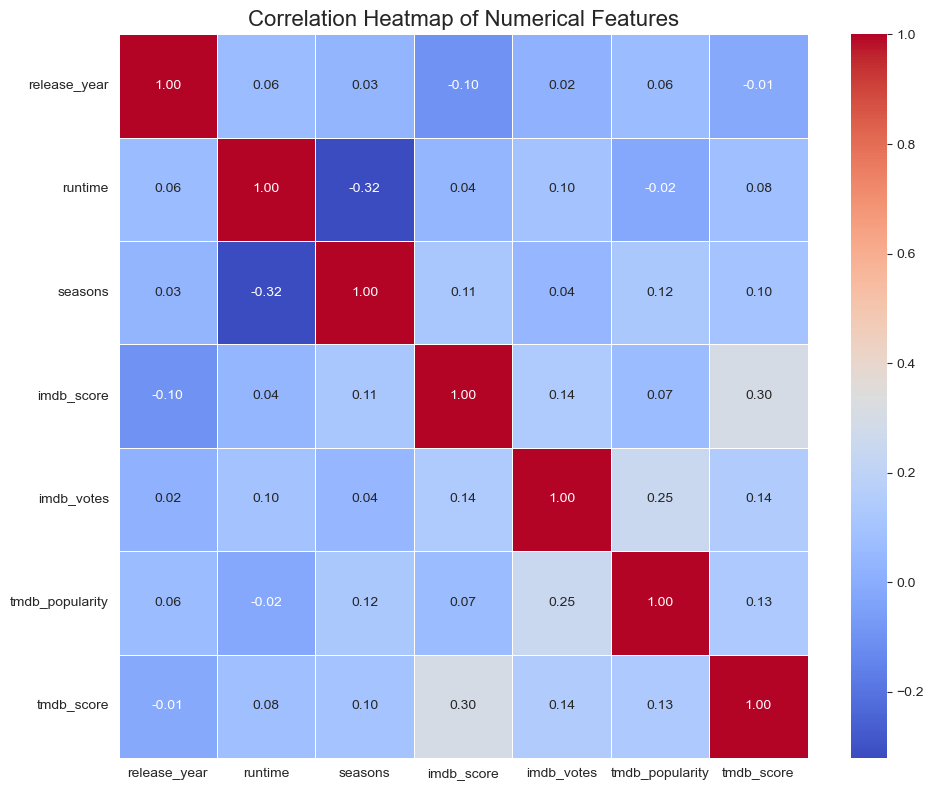

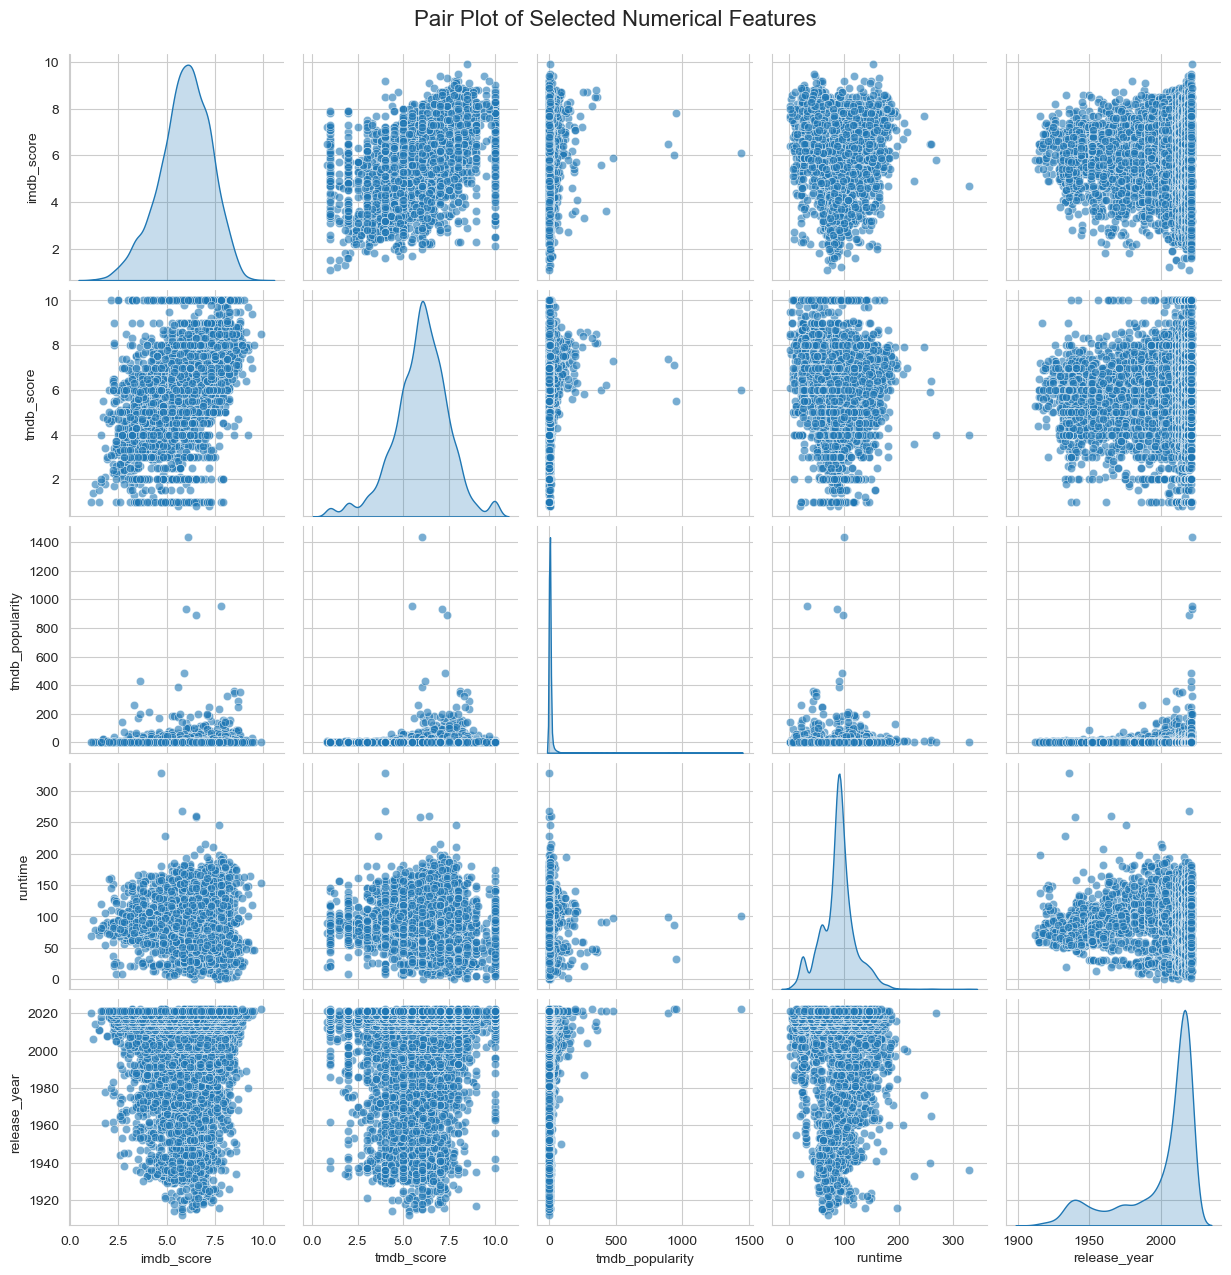


--- EDA and Visualization Complete ---
All charts generated and insights analyzed.


In [1]:
# ==============================================================================
# Project: Amazon Prime TV Shows and Movies Exploratory Data Analysis (EDA)
# Author: Your Name/Team Name (Replace with your details)
# Date: July 21, 2025
# Description: This notebook performs a comprehensive EDA on Amazon Prime Video's
#              content data to extract valuable business insights.
# ==============================================================================

# --- 1. Import Libraries ---
# Essential libraries for data manipulation, numerical operations, and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # Used for safely evaluating string literals containing Python structures (like lists)
import os # For checking file existence and managing output

# Set a consistent style for all plots for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust figure resolution for better quality

# ==============================================================================
# SECTION 1: KNOW YOUR DATA & DATA WRANGLING
# This section focuses on loading the datasets, initial inspection, handling
# duplicates, managing missing values, converting data types, and merging.
# The goal is to make the dataset analysis-ready.
# ==============================================================================

print("--- Starting Data Loading and Wrangling ---")

# --- 1.1 Dataset Loading with Exception Handling ---
# Safely load the datasets. If files are not found, an error will be caught.
try:
    titles_df = pd.read_csv('titles.csv')
    credits_df = pd.read_csv('credits.csv')
    print("Datasets loaded successfully: titles.csv, credits.csv")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure 'titles.csv' and 'credits.csv' are in the correct directory.")
    # Exit or raise error if critical files are missing
    raise

# --- 1.2 Dataset First View (Initial Inspection) ---
# Display the first few rows to get a glimpse of the data structure.
print("\n--- Titles DataFrame Head ---")
print(titles_df.head())
print("\n--- Credits DataFrame Head ---")
print(credits_df.head())

# --- 1.3 Dataset Rows & Columns Count ---
# Check the dimensions of the DataFrames.
print(f"\nTitles DataFrame has {titles_df.shape[0]} rows and {titles_df.shape[1]} columns.")
print(f"Credits DataFrame has {credits_df.shape[0]} rows and {credits_df.shape[1]} columns.")

# --- 1.4 Dataset Information (Data Types & Non-Null Counts) ---
# Crucial for identifying data types and initial assessment of missing values.
print("\n--- Titles DataFrame Info ---")
titles_df.info()
print("\n--- Credits DataFrame Info ---")
credits_df.info()

# --- 1.5 Duplicate Values Handling ---
# Identify and remove any duplicate rows to maintain data integrity.
print("\n--- Duplicate Value Handling ---")
print(f"Number of duplicate rows in titles_df before dropping: {titles_df.duplicated().sum()}")
titles_df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows in titles_df after dropping: {titles_df.duplicated().sum()}")

print(f"Number of duplicate rows in credits_df before dropping: {credits_df.duplicated().sum()}")
credits_df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows in credits_df after dropping: {credits_df.duplicated().sum()}")

# --- 1.6 Missing Values/Null Values Handling ---
# Fill missing values based on their type and context to make data complete for analysis.
print("\n--- Missing Value Handling ---")

# --- For titles_df ---
# Fill missing text/categorical data. Assign back to avoid FutureWarnings.
titles_df['description'] = titles_df['description'].fillna('No description available')
titles_df['age_certification'] = titles_df['age_certification'].fillna('Not Rated')

# Fill missing numerical scores/popularity/votes with 0.
titles_df['imdb_score'] = titles_df['imdb_score'].fillna(0)
titles_df['imdb_votes'] = titles_df['imdb_votes'].fillna(0)
titles_df['tmdb_popularity'] = titles_df['tmdb_popularity'].fillna(0)
titles_df['tmdb_score'] = titles_df['tmdb_score'].fillna(0)

# For 'seasons' column: relevant only for 'SHOW', so fill NaN with 0 for 'MOVIE' and convert to int.
titles_df['seasons'] = titles_df['seasons'].fillna(0).astype(int)

# --- For credits_df ---
# Fill missing 'character' names (common for directors or uncredited roles).
credits_df['character'] = credits_df['character'].fillna('Not Applicable')

# Display remaining null counts to verify cleaning.
print("\nNull counts in titles_df after handling:\n", titles_df.isnull().sum())
print("\nNull counts in credits_df after handling:\n", credits_df.isnull().sum())


# --- 1.7 Data Type Conversion / Parse List-like Strings ---
# Convert string representations of lists (e.g., '["action", "drama"]') into actual Python lists.
# This is crucial for proper iteration and counting of individual elements.
def parse_list_string(s):
    try:
        # ast.literal_eval is safer than eval() for parsing string literals
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        # Return an empty list for any unparseable or invalid string entries
        return []
    except TypeError: # Handles cases where 's' might already be a non-string type (e.g., float NaN)
        return []

titles_df['genres'] = titles_df['genres'].apply(parse_list_string)
titles_df['production_countries'] = titles_df['production_countries'].apply(parse_list_string)


# --- 1.8 Merge DataFrames ---
# Merge titles_df and credits_df on the 'id' column.
# A left merge ensures all titles from titles_df are retained, and corresponding credit information is added where available.
merged_df = pd.merge(titles_df, credits_df, on='id', how='left')

print("\n--- Merged DataFrame Info ---")
merged_df.info()
print("\nNull counts in merged_df after merging:\n", merged_df.isnull().sum())

print("\n--- Data Wrangling Complete ---")
print("Dataset is now analysis-ready.")

# ==============================================================================
# SECTION 2: EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATIONS
# This section generates 15 different charts to answer key business questions.
# ==============================================================================

print("\n--- Starting Exploratory Data Analysis and Visualizations ---")

# --- Chart 1: Distribution of Movies vs. TV Shows ---
# Objective: Understand the primary content type distribution on the platform.
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=titles_df, palette='viridis')
plt.title('Distribution of Movies vs. TV Shows on Amazon Prime', fontsize=16)
plt.xlabel('Content Type', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('1_content_type_distribution.png')
plt.show()

# --- Chart 2: Top 15 Most Common Genres (Overall) ---
# Objective: Identify the most prevalent content genres across the entire platform.
# Explode the genres column to count individual genres
titles_exploded_genres = titles_df.explode('genres')
# Filter out any potential empty strings that might have resulted from parsing malformed lists
titles_exploded_genres = titles_exploded_genres[titles_exploded_genres['genres'] != '']
genre_counts = titles_exploded_genres['genres'].value_counts().head(15)

plt.figure(figsize=(12, 8))
# Corrected syntax for palette without hue (for future compatibility)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='mako', hue=genre_counts.index, legend=False)
plt.title('Top 15 Most Common Genres on Amazon Prime', fontsize=16)
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('2_top_genres_overall.png')
plt.show()

# --- Chart 3: Top 10 Genres for Movies vs. TV Shows ---
# Objective: Compare genre distribution within Movies and TV Shows specifically.
# Explode again after filtering for any potential errors
titles_exploded_genres = titles_df.explode('genres')
titles_exploded_genres = titles_exploded_genres[titles_exploded_genres['genres'] != '']

top_movies_genres = titles_exploded_genres[titles_exploded_genres['type'] == 'MOVIE']['genres'].value_counts().head(10)
top_shows_genres = titles_exploded_genres[titles_exploded_genres['type'] == 'SHOW']['genres'].value_counts().head(10)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(x=top_movies_genres.values, y=top_movies_genres.index, palette='rocket', hue=top_movies_genres.index, legend=False)
plt.title('Top 10 Genres for Movies', fontsize=14)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
sns.barplot(x=top_shows_genres.values, y=top_shows_genres.index, palette='magma', hue=top_shows_genres.index, legend=False)
plt.title('Top 10 Genres for TV Shows', fontsize=14)
plt.xlabel('Number of TV Shows', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('3_genre_distribution_by_type.png')
plt.show()

# --- Chart 4: Age Certification Distribution ---
# Objective: Understand the age suitability distribution of content.
age_cert_counts = titles_df['age_certification'].value_counts().sort_index()

plt.figure(figsize=(10, 7))
sns.barplot(x=age_cert_counts.index, y=age_cert_counts.values, palette='cubehelix', hue=age_cert_counts.index, legend=False)
plt.title('Distribution of Age Certifications on Amazon Prime', fontsize=16)
plt.xlabel('Age Certification', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('4_age_certification_distribution.png')
plt.show()

# --- Chart 5: Top 10 Production Countries ---
# Objective: Identify the main geographical sources of content.
titles_exploded_countries = titles_df.explode('production_countries')
titles_exploded_countries = titles_exploded_countries[titles_exploded_countries['production_countries'] != '']

country_counts = titles_exploded_countries['production_countries'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=country_counts.values, y=country_counts.index, palette='crest', hue=country_counts.index, legend=False)
plt.title('Top 10 Production Countries on Amazon Prime', fontsize=16)
plt.xlabel('Number of Titles Produced', fontsize=12)
plt.ylabel('Production Country', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('5_top_production_countries.png')
plt.show()

# --- Chart 6: Content Type Distribution by Top 10 Production Countries ---
# Objective: Analyze the mix of Movies vs. TV Shows from top producing countries.
titles_exploded_countries = titles_df.explode('production_countries')
titles_exploded_countries = titles_exploded_countries[titles_exploded_countries['production_countries'] != '']

top_countries = titles_exploded_countries['production_countries'].value_counts().head(10).index.tolist()
df_top_countries = titles_exploded_countries[titles_exploded_countries['production_countries'].isin(top_countries)]

country_type_counts = df_top_countries.groupby(['production_countries', 'type']).size().unstack(fill_value=0)
country_type_counts = country_type_counts[['MOVIE', 'SHOW']] # Ensure consistent order for stacking
country_type_counts['Total'] = country_type_counts['MOVIE'] + country_type_counts['SHOW']
country_type_counts = country_type_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

plt.figure(figsize=(12, 8))
country_type_counts.plot(kind='bar', stacked=True, colormap='Spectral', ax=plt.gca())
plt.title('Content Type Distribution by Top 10 Production Countries', fontsize=16)
plt.xlabel('Production Country', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Content Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('6_content_type_by_country_stacked_bar.png')
plt.show()

# --- Chart 7: Number of Titles Released Per Year ---
# Objective: Analyze the growth trend of Amazon Prime's content library over time.
releases_per_year = titles_df['release_year'].value_counts().sort_index()

plt.figure(figsize=(15, 7))
sns.lineplot(x=releases_per_year.index, y=releases_per_year.values, marker='o', color='purple')
plt.title('Number of Titles Released Per Year on Amazon Prime', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('7_releases_per_year_line_plot.png')
plt.show()

# --- Chart 8: Evolution of Top 5 Genres Over Time (Stacked Area Plot) ---
# Objective: Show how the prominence of top genres has changed over time.
titles_exploded_genres = titles_df.explode('genres')
titles_exploded_genres = titles_exploded_genres[titles_exploded_genres['genres'] != '']

all_genres = titles_exploded_genres['genres'].tolist()
top_n_genres = pd.Series(all_genres).value_counts().head(5).index.tolist()

df_top_genres_over_time = titles_exploded_genres[titles_exploded_genres['genres'].isin(top_n_genres)]
genre_release_counts = df_top_genres_over_time.groupby(['release_year', 'genres']).size().unstack(fill_value=0)

min_year = titles_df['release_year'].min()
max_year = titles_df['release_year'].max()
all_years = pd.Series(range(min_year, max_year + 1), name='release_year')
genre_release_counts = genre_release_counts.reindex(all_years, fill_value=0)

plt.figure(figsize=(15, 8))
genre_release_counts.plot(kind='area', stacked=True, alpha=0.7, ax=plt.gca(), cmap='viridis')
plt.title('Evolution of Top 5 Genres Over Time on Amazon Prime', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('8_genre_evolution_over_time_area_plot.png')
plt.show()

# --- Chart 9: Average IMDb Score Over Time ---
# Objective: Assess if content quality (by IMDb score) is improving, declining, or stable over time.
# Filter out 0 IMDb scores (imputed NaNs) for a meaningful average.
rated_titles_avg = titles_df[titles_df['imdb_score'] > 0]
avg_imdb_score_per_year = rated_titles_avg.groupby('release_year')['imdb_score'].mean()

plt.figure(figsize=(15, 7))
sns.lineplot(x=avg_imdb_score_per_year.index, y=avg_imdb_score_per_year.values, marker='o', color='darkorange')
plt.title('Average IMDb Score of Titles Over Time on Amazon Prime', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average IMDb Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('9_avg_imdb_score_over_time.png')
plt.show()

# --- Chart 10: Distribution of IMDb and TMDB Scores (Histograms) ---
# Objective: Visualize the spread and frequency of content ratings from two different sources.
# Filter for actual scores (>0) for meaningful distributions.
rated_titles_df_scores = titles_df[(titles_df['imdb_score'] > 0) & (titles_df['tmdb_score'] > 0)]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(rated_titles_df_scores['imdb_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of IMDb Scores', fontsize=14)
plt.xlabel('IMDb Score', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(rated_titles_df_scores['tmdb_score'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of TMDB Scores', fontsize=14)
plt.xlabel('TMDB Score', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('10_imdb_tmdb_score_distribution_histograms.png')
plt.show()

# --- Chart 11: IMDb Score vs. TMDB Score (Scatter Plot) ---
# Objective: Examine the relationship/correlation between IMDb and TMDB scores.
# Filter for actual scores (>0).
rated_titles_df_scores = titles_df[(titles_df['imdb_score'] > 0) & (titles_df['tmdb_score'] > 0)]

plt.figure(figsize=(8, 7))
sns.scatterplot(x='imdb_score', y='tmdb_score', data=rated_titles_df_scores, alpha=0.6, color='darkblue')
plt.title('IMDb Score vs. TMDB Score', fontsize=16)
plt.xlabel('IMDb Score', fontsize=12)
plt.ylabel('TMDB Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('11_imdb_tmdb_score_scatter.png')
plt.show()

# --- Chart 12: IMDb Score vs. TMDB Popularity (Scatter Plot) ---
# Objective: Understand how critical acclaim relates to perceived popularity.
# Filter for actual scores/popularity (>0).
rated_titles_df_popularity = titles_df[(titles_df['imdb_score'] > 0) & (titles_df['tmdb_popularity'] > 0)]

plt.figure(figsize=(8, 7))
sns.scatterplot(x='imdb_score', y='tmdb_popularity', data=rated_titles_df_popularity, alpha=0.6, color='darkgreen')
plt.title('IMDb Score vs. TMDB Popularity', fontsize=16)
plt.xlabel('IMDb Score', fontsize=12)
plt.ylabel('TMDB Popularity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('12_imdb_tmdb_popularity_scatter.png')
plt.show()

# --- Chart 13: Top 10 IMDb-Rated Movies (with min votes) ---
# Objective: Identify the most critically acclaimed movies based on IMDb ratings, filtering for reliability.
# Filter for movies with actual scores and a minimum number of votes for reliability.
top_rated_movies = titles_df[(titles_df['type'] == 'MOVIE') & (titles_df['imdb_score'] > 0) & (titles_df['imdb_votes'] >= 100)].sort_values(by='imdb_score', ascending=False).head(10)

plt.figure(figsize=(10, 7))
sns.barplot(x='imdb_score', y='title', data=top_rated_movies, palette='Blues_d')
plt.title('Top 10 IMDb-Rated Movies (Min. 100 Votes)', fontsize=16)
plt.xlabel('IMDb Score', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('13_top_imdb_rated_movies.png')
plt.show()

# --- Chart 14: Correlation Heatmap of Numerical Features ---
# Objective: Visualize linear relationships between all numerical features.
# Select only numerical columns for correlation calculation.
numerical_cols = titles_df.select_dtypes(include=np.number).columns
correlation_matrix = titles_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
# Use 'coolwarm' for a diverging colormap, 'annot=True' to show correlation values.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0) # Ensure y-axis labels are readable
plt.tight_layout()
plt.savefig('14_correlation_heatmap.png')
plt.show()

# --- Chart 15: Pair Plot of Selected Numerical Features ---
# Objective: Visualize relationships between selected numerical features and their individual distributions.
# Select a few relevant numerical columns for the pair plot to maintain readability.
selected_num_cols = ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime', 'release_year']

# Filter out 0s for scores/popularity as they were imputed NaNs for true analysis, only for this plot.
pair_plot_df = titles_df[
    (titles_df['imdb_score'] > 0) &
    (titles_df['tmdb_score'] > 0) &
    (titles_df['tmdb_popularity'] > 0)
][selected_num_cols]

# Use diag_kind='kde' for density plots on the diagonal (distributions)
# plot_kws={'alpha': 0.6} for better visibility of overlapping points in scatter plots
sns.pairplot(pair_plot_df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Selected Numerical Features', y=1.02, fontsize=16) # Adjust title position
plt.savefig('15_pair_plot_numerical_features.png')
plt.show()

print("\n--- EDA and Visualization Complete ---")
print("All charts generated and insights analyzed.")